In this notebook we demonstrate usages of the two moduldes `rep_drift` and `visualize_drift`.

-------
### Similarity analysis and PCA

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from scipy.stats import linregress

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

import pprint

In [2]:
# import our own functions
import rep_drift, visualize_drift

In [3]:
boc = BrainObservatoryCache()

In [26]:
# can check doc strings of the functions using help():

help(rep_drift.get_datasets)

Help on function get_datasets in module rep_drift:

get_datasets(boc, container_id)
    Fetch the three experiments in one container, and order them according temporally. 
    
    Args:
        boc                  : allen SDK cache object
        container_id(int)    : id of the experiment container
    
    Returns:
        datasets(list)       : list of 3 SDK experiment data object in the container
        ordered_days(np arr) : length 3, treating date of exp1 as day 0.



In [27]:
# use one example container:
datasets, ordered_days = rep_drift.get_datasets(boc, 540993888)

In [6]:
# get just one experiment session:
cell_ids_0, dff_vals_0, run_vals_0 = rep_drift.get_response_vals(datasets[0])

In [7]:
# get crrelation matrix and angle matrix:
corrs_s0, angles_s0 = rep_drift.calc_similarity(dff_vals_0)

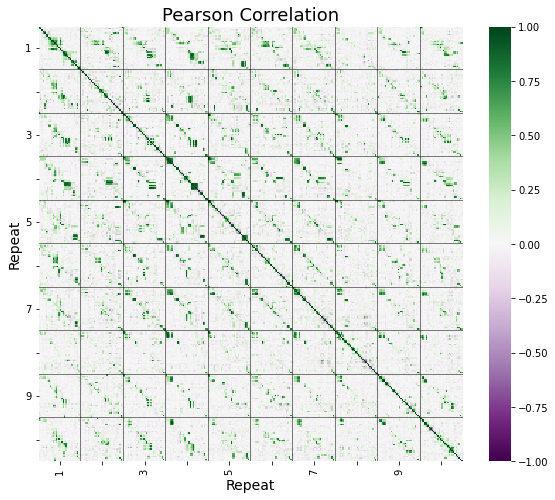

In [8]:
# plot correation, n_repeat_plot can take 10 or 5:
visualize_drift.plot_corr(corrs_s0, n_repeat_plot= 10)

In [ ]:
visualize_drift.plot_angle(angles_s0, n_repeat_plot= 10)

In [9]:
# get response vectors of all three sessions, align the shared neurons:
dff_vals_container, run_vals_container = rep_drift.align_response_vals(datasets)

In [10]:
# calculate cross session similarities:
across_session_corrs, across_session_angles =  rep_drift.calc_cross_similarity(dff_vals_container)

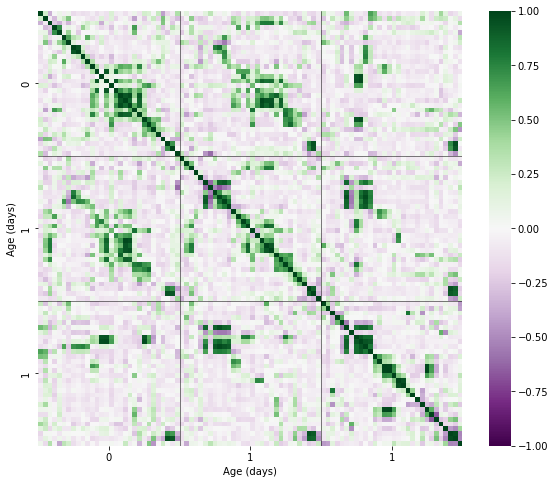

In [11]:
# plot cross session:
visualize_drift.plot_cross_corr(across_session_corrs, ordered_days)

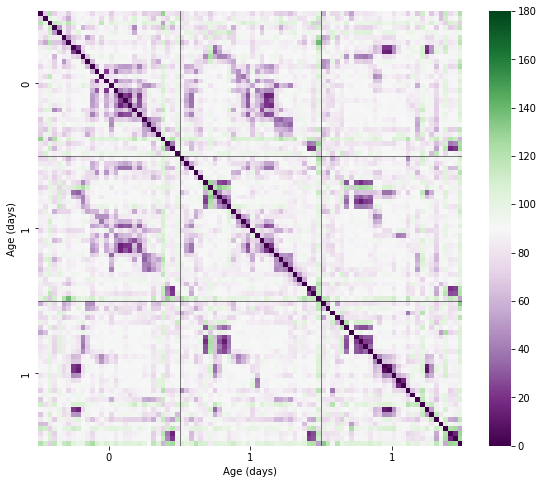

In [12]:
visualize_drift.plot_cross_angle(across_session_angles, ordered_days)

In [13]:
# get mean response vector:
mean_vecs = rep_drift.calc_mean_vecs(dff_vals_container)

In [29]:
# do PCA for all, store the pca models, variance explained, and effective dimensions:
print(help(rep_drift.do_PCA))
pcas_session, vars_session, dims_session = rep_drift.do_PCA(dff_vals_container)

Help on function do_PCA in module rep_drift:

do_PCA(dff_vals_container)
    For every stimulus group (response vectors to a stimuli of all repeats in one session), do PC decomposition.  
    
    Args:
        dff_vals_container(list)  : list containing dff_vals for each of the 3 seessions, response vectors are only of the shared neurons
    
    Returns: 
        pcas_session(list)        : 2-d list (3 x n_divs) containing pca models for each stimulus group
        vars_session(np arr)      : (n_sessions, n_divs, n_repeats), variance explained of each pc direction (# of pcs = n_repeats)
        dims_session(np arr)      : (n_sessions, n_divs), effective dimension of each stimulus groupx

None


-----

### Aitkens 2(b) style plot:

In [15]:
c_vals = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'gray']
c_vals_l = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato', 'lightgray']

Text(0, 0.5, 'PC2 (Group 1)')

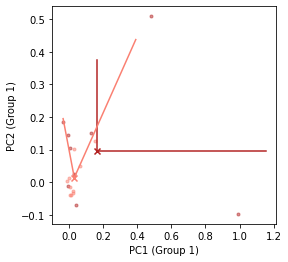

In [16]:
pc1 = 0
pc2 = 1

session_idx_early = 0
session_idx_late = 1

# pick block 0
stimuli_idx = 15

stimuli_pca_early = pcas_session[session_idx_early][stimuli_idx]

fig, ax = plt.subplots(1, 1, figsize=(4,4))

drift_pair = (session_idx_early, session_idx_late)

pca_scale = 1.5 

colors = (c_vals[0], c_vals_l[0])
for session_idx_idx, session_idx in enumerate(drift_pair):

    dff_vals_stimuli = dff_vals_container[session_idx][:, stimuli_idx, :]
    stimuli_pca = pcas_session[session_idx][stimuli_idx]

    dff_vals_pca = np.matmul(dff_vals_stimuli, stimuli_pca_early.components_.T) # yeah notic that .components returns n eigen vectors, essentionally W inverse. 

    ax.scatter(dff_vals_pca[:, pc1], dff_vals_pca[:, pc2], marker='.', 
            color=colors[session_idx_idx], alpha=0.5)
    
    stimuli_mean = np.mean(dff_vals_pca, axis=0)

    ax.scatter(stimuli_mean[pc1], stimuli_mean[pc2],
               marker='x', color=colors[session_idx_idx])
    
    pcas_proj =  np.matmul(stimuli_pca.components_, stimuli_pca_early.components_.T)

    for pc_idx in (pc1, pc2):
        pcas_proj[pc_idx] = (pca_scale * stimuli_pca.explained_variance_ratio_[pc_idx] *
                             pcas_proj[pc_idx] / np.linalg.norm(pcas_proj[pc_idx]))

        ax.plot([stimuli_mean[pc1], stimuli_mean[pc1]+pcas_proj[pc_idx, pc1]],
                [stimuli_mean[pc2], stimuli_mean[pc2]+pcas_proj[pc_idx, pc2]],
                color=colors[session_idx_idx])


ax.set_xlabel('PC1 (Group 1)')
ax.set_ylabel('PC2 (Group 1)')



-----

### Reproduce Aitkens 3(a), 3(b), 3(c):

Note that they use all containers. We only use one container as an example.

In [30]:
print(help(rep_drift.drift_geometry))
pca1_var, pca_drift_magnitude, pca_drift_align, pca1_var_exp2_session = rep_drift.drift_geometry(dff_vals_container, pcas_session, vars_session, mean_vecs)

Help on function drift_geometry in module rep_drift:

drift_geometry(dff_vals_container, pcas_session, vars_session, mean_vecs)
    Function for correlating the geometric properties of the variational spaces before and after drift, for the three drift pairs:  1-2, 2-3, 1-3.
    
    The geometric properties include: 
    1) variance explained in each pc direction before and after drift;
    2) drift magnitude in the early session space;
    3) drift angle in the early session space.
    
    Args:
        dff_vals_container(list)        : list containing dff_vals for each of the 3 seessions, response vectors are only of the shared neurons
        pcas_session(list)              : 2-d list (3 x n_divs) containing pca models for each stimulus group
        vars_session(np arr)            : (n_sessions, n_divs, n_repeats), variance explained of each pc direction (# of pcs = n_repeats)
        mean_vecs(np arr)               : (n_sessions, n_divs, n_shared_neurons), mean response vector
  

In [18]:
# average over all 30 stimuli:
vars_drift_early_flat = np.mean(pca1_var, axis = 1).flatten()

pca_drift_magnitude_flat = np.mean(pca_drift_magnitude, axis = 1).flatten()
pca_drift_align_flat = np.mean(pca_drift_align, axis = 1).flatten()

pca1_var_exp2_session_flat = np.mean(pca1_var_exp2_session, axis = 1).flatten()


In [31]:
# threshold variance expalined to be greater than 1e-5, (there is a very distinct gap):
min_var_exp = 1e-5
passed_var_idx  = vars_drift_early_flat > min_var_exp

vars_drift_early_flat_filtered = vars_drift_early_flat[passed_var_idx]

pca_drift_magnitude_flat_filtered = pca_drift_magnitude_flat[passed_var_idx]
pca_drift_align_flat_filtered = pca_drift_align_flat[passed_var_idx]

pca1_var_exp2_session_flat_filtered = pca1_var_exp2_session_flat[passed_var_idx]

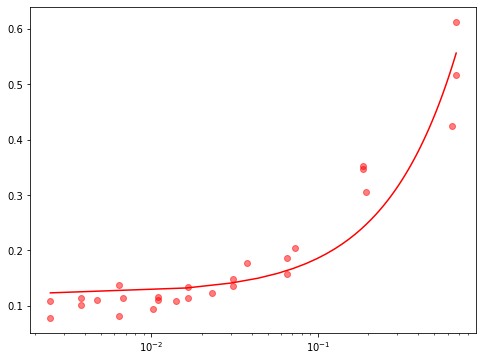

In [20]:
# 3 a):
fig, ax = plt.subplots(1, 1, figsize = (8,6))

x = vars_drift_early_flat_filtered
y = pca_drift_magnitude_flat_filtered

ax.scatter(x, y, c = 'r', alpha = .5)
reg = linregress(x, y)

reg_x = np.linspace(np.min(x), np.max(x), num=50)
reg_y = reg.slope * reg_x + reg.intercept
ax.plot(reg_x, reg_y, color= 'r')


ax.set_xscale('log')


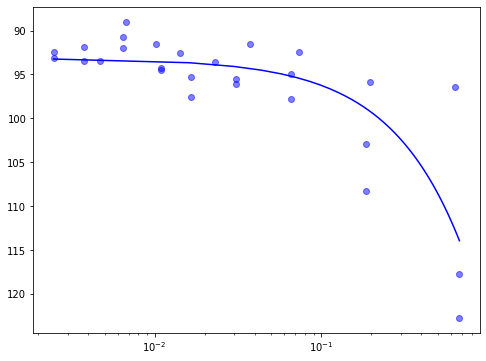

In [21]:
# 3 b):

fig, ax = plt.subplots(1, 1, figsize = (8,6))
x = vars_drift_early_flat_filtered
y = pca_drift_align_flat_filtered
ax.scatter(x, y, c = 'b', alpha = .5)

reg = linregress(x, y)

reg_x = np.linspace(np.min(x), np.max(x), num=50)
reg_y = reg.slope * reg_x + reg.intercept
ax.plot(reg_x, reg_y, color= 'b')


ax.set_xscale('log')
ax.invert_yaxis()

Text(0, 0.5, 'log(Var. Exp.) (later)')

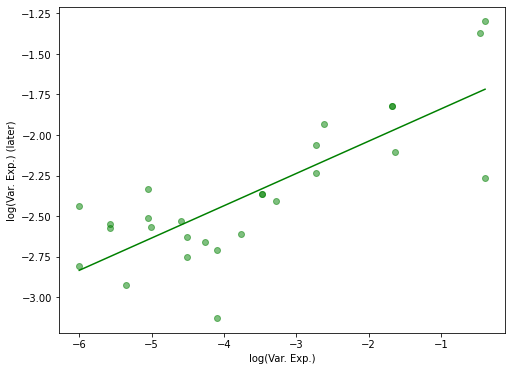

In [22]:
# 3 c):
fig, ax = plt.subplots(1, 1, figsize = (8,6))

x = np.log(vars_drift_early_flat_filtered)
y = np.log(pca1_var_exp2_session_flat_filtered)

ax.scatter(x, y, c = 'g', alpha = .5)


reg = linregress(x, y)

reg_x = np.linspace(np.min(x), np.max(x), num=50)
reg_y = reg.slope * reg_x + reg.intercept
ax.plot(reg_x, reg_y, color= 'g')

ax.set_xlabel('log(Var. Exp.)')
ax.set_ylabel('log(Var. Exp.) (later)')
